In [286]:
from pandas.io.sas.sas_constants import os_name_offset

"""
Clase: rnn

Objetivo: modelo

Cambios:

    1. Creacion de modelo aquesada 07-07-2025
"""

'\nClase: rnn\n\nObjetivo: modelo\n\nCambios:\n\n    1. Creacion de modelo aquesada 07-07-2025\n'

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from src.utils.metrics import obtener_ruta_app
import os



In [9]:
ruta = os.path.join(obtener_ruta_app(),"data/processed/ANN/recomendaciones.csv")

df = pd.read_csv(ruta,encoding = "ISO-8859-1",delimiter=',')

In [10]:
df

,YEAR,MONTH,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion
0,1981,JAN,2.64,23.90,14.19,88.79,3.81,fertilizacion
1,1982,JAN,3.30,24.54,14.02,89.43,3.18,fertilizacion
2,1983,JAN,1.38,26.13,15.75,88.61,6.46,poda_preventiva
3,1984,JAN,0.69,23.68,13.14,87.41,8.35,riego
4,1985,JAN,1.94,23.45,14.37,86.96,8.05,riego
...,...,...,...,...,...,...,...,...
523,2020,DEC,10.77,24.26,13.57,91.87,6.02,poda_preventiva
524,2021,DEC,4.18,24.62,16.47,91.61,3.57,fertilizacion
525,2022,DEC,3.39,24.12,15.47,90.88,7.80,poda_preventiva
526,2023,DEC,4.84,25.70,16.68,91.62,6.58,poda_preventiva


In [11]:
df.drop(columns=["YEAR", "MONTH"], inplace=True)

In [12]:
#Transformar variables categoricas
dummies = pd.get_dummies(df[['Recomendacion']]) #se puede añadir drop_first=True evita redundancia y evita crear una columna por cada variable
df_post = pd.concat([df,dummies],axis=1)
df_post = df_post.drop(['Recomendacion'],axis=1)

In [13]:
df_post

,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
0,2.64,23.90,14.19,88.79,3.81,True,False,False
1,3.30,24.54,14.02,89.43,3.18,True,False,False
2,1.38,26.13,15.75,88.61,6.46,False,True,False
3,0.69,23.68,13.14,87.41,8.35,False,False,True
4,1.94,23.45,14.37,86.96,8.05,False,False,True
...,...,...,...,...,...,...,...,...
523,10.77,24.26,13.57,91.87,6.02,False,True,False
524,4.18,24.62,16.47,91.61,3.57,True,False,False
525,3.39,24.12,15.47,90.88,7.80,False,True,False
526,4.84,25.70,16.68,91.62,6.58,False,True,False


In [14]:
from sklearn.preprocessing import StandardScaler

# Normalizar columnas numericas
columnas_numericas = ['lluvia_mm', 'temp_max', 'temp_min', 'humedad','ph_suelo']

# Escalado
scaler = StandardScaler()
df_post[columnas_numericas] = scaler.fit_transform(df_post[columnas_numericas])

In [15]:
df_post

,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
0,-0.692443,-1.449126,-0.972614,0.119914,-1.222913,True,False,False
1,-0.517110,-1.060796,-1.124801,0.266401,-1.592142,True,False,False
2,-1.027171,-0.096037,0.423922,0.078714,0.330190,False,True,False
3,-1.210474,-1.582615,-1.912590,-0.195949,1.437875,False,False,True
4,-0.878403,-1.722171,-0.811475,-0.298948,1.262052,False,False,True
...,...,...,...,...,...,...,...,...
523,1.467346,-1.230690,-1.527648,0.824882,0.072316,False,True,False
524,-0.283332,-1.012254,1.068477,0.765372,-1.363572,True,False,False
525,-0.493201,-1.315638,0.173261,0.598285,1.115533,False,True,False
526,-0.107998,-0.356946,1.256472,0.767661,0.400519,False,True,False


In [16]:
X = df_post.drop(['Recomendacion_fertilizacion','Recomendacion_poda_preventiva','Recomendacion_riego'],axis=1).values

In [17]:
y = df_post[['Recomendacion_fertilizacion','Recomendacion_poda_preventiva','Recomendacion_riego']]

In [18]:
y

,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
0,True,False,False
1,True,False,False
2,False,True,False
3,False,False,True
4,False,False,True
...,...,...,...
523,False,True,False
524,True,False,False
525,False,True,False
526,False,True,False


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=101,stratify=y)

In [20]:
X_train.shape

(396, 5)

In [21]:
X_test.shape

(132, 5)

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [23]:
X_train.shape

(396, 5)

In [24]:
X_test.shape

(132, 5)

In [25]:
X_train

array([[0.12596302, 0.1391201 , 0.33762058, 0.76134216, 0.02675585],
       [0.0770416 , 0.18787158, 0.2926045 , 0.69848771, 0.66889632],
       [0.16294299, 0.20808561, 0.85209003, 0.84593573, 0.75585284],
       ...,
       [0.53004622, 0.27467301, 0.57234727, 0.95037807, 0.98327759],
       [0.38174114, 0.21403092, 0.36495177, 0.86200378, 0.5451505 ],
       [0.1348228 , 0.32104637, 0.62379421, 0.72873346, 0.409699  ]])

In [26]:
X_test

array([[ 4.27580894e-02,  8.32342449e-02,  6.44694534e-01,
         6.89981096e-01,  3.49498328e-01],
       [ 2.26502311e-01,  2.46135553e-01,  6.92926045e-01,
         8.50189036e-01,  9.26421405e-01],
       [ 1.25577812e-01,  3.80499405e-01,  2.78135048e-01,
         6.53591682e-01,  1.50501672e-01],
       [ 1.82203390e-01,  3.80499405e-01,  6.20578778e-01,
         8.30340265e-01,  7.19063545e-02],
       [ 2.52696456e-01,  5.11296076e-01,  5.65916399e-01,
         6.55009452e-01,  8.16053512e-01],
       [ 3.29352851e-01,  2.66349584e-01,  4.46945338e-01,
         8.79489603e-01,  8.67892977e-01],
       [ 4.13713405e-01,  4.06658740e-01,  6.68810289e-01,
         8.55860113e-01,  2.87625418e-01],
       [ 4.08320493e-02,  2.87752675e-01,  6.44694534e-01,
         7.70321361e-01,  9.63210702e-01],
       [ 4.42218798e-01,  3.00832342e-01,  2.09003215e-01,
         9.05009452e-01,  9.93311037e-01],
       [ 2.22650231e-01,  3.03210464e-01,  6.59163987e-01,
         8.51134216e-01

In [27]:
X_train

array([[0.12596302, 0.1391201 , 0.33762058, 0.76134216, 0.02675585],
       [0.0770416 , 0.18787158, 0.2926045 , 0.69848771, 0.66889632],
       [0.16294299, 0.20808561, 0.85209003, 0.84593573, 0.75585284],
       ...,
       [0.53004622, 0.27467301, 0.57234727, 0.95037807, 0.98327759],
       [0.38174114, 0.21403092, 0.36495177, 0.86200378, 0.5451505 ],
       [0.1348228 , 0.32104637, 0.62379421, 0.72873346, 0.409699  ]])

In [28]:
X_train.max()

np.float64(1.0)

In [29]:
model = Sequential()
# Elegir número de capas (layers)
#https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
num_neuronas = X_train.shape[1]
# Indicar tantas neuronas de salida como clases a predecir
num_neuronas_salida = y_train.shape[1]
#Capa inicial usando Input
model.add(Dense(units=num_neuronas, activation='relu'))
model.add(Dense(units=num_neuronas, activation='relu'))
model.add(Dense(units=num_neuronas, activation='relu'))
model.add(Dense(num_neuronas_salida, activation='softmax'))  # softmax para multiclase - softmax activation distribuye la probabilidad sobre cada nodo de salida (clase)

# Para clasificación multiclase "categorical_crossentropy"
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['categorical_accuracy'])

In [30]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [32]:
# Entrenar el modelo
model.fit(x=X_train,
          y=y_train,
          epochs=1000,
          batch_size=256,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - categorical_accuracy: 0.2771 - loss: 1.1867 - val_categorical_accuracy: 0.2879 - val_loss: 1.1670
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - categorical_accuracy: 0.2806 - loss: 1.1795 - val_categorical_accuracy: 0.2879 - val_loss: 1.1608
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.2845 - loss: 1.1667 - val_categorical_accuracy: 0.2879 - val_loss: 1.1549
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.2832 - loss: 1.1632 - val_categorical_accuracy: 0.2879 - val_loss: 1.1494
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_accuracy: 0.2832 - loss: 1.1566 - val_categorical_accuracy: 0.2879 - val_loss: 1.1443
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_accuracy: 0.2724 - loss: 1.1539 - val_categorical_accuracy: 0.2879 - val_loss: 1.1394
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_accuracy: 0.2815 - loss: 1.1

<Axes: >

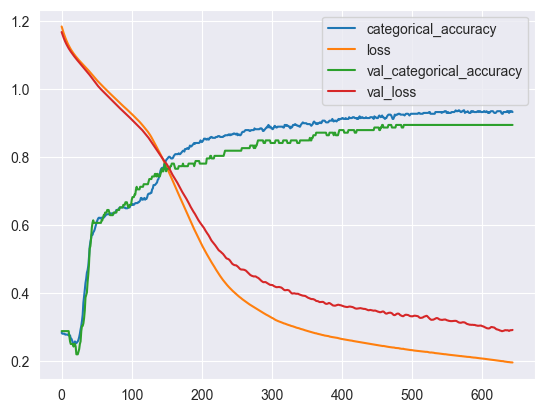

In [33]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [339]:
#Evaluacion del Modelo


In [34]:
#Predicción

predictions = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [35]:
y_test

,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
491,True,False,False
334,False,True,False
125,True,False,False
419,True,False,False
203,False,False,True
...,...,...,...
256,True,False,False
477,True,False,False
281,False,True,False
320,True,False,False


In [36]:
predictions

array([[9.83888984e-01, 5.16710151e-03, 1.09438496e-02],
       [1.45113165e-03, 9.78519142e-01, 2.00297292e-02],
       [9.60637867e-01, 3.46006273e-04, 3.90161127e-02],
       [9.62735713e-01, 8.11719729e-05, 3.71831246e-02],
       [2.12890888e-03, 2.39203930e-01, 7.58667231e-01],
       [3.91375320e-03, 9.79733884e-01, 1.63523722e-02],
       [9.88894582e-01, 1.21714827e-03, 9.88821406e-03],
       [2.77644023e-03, 7.24245667e-01, 2.72977889e-01],
       [8.76569748e-03, 9.68239486e-01, 2.29948759e-02],
       [9.09683585e-01, 5.98811619e-02, 3.04351915e-02],
       [9.85016346e-01, 7.55574228e-03, 7.42797181e-03],
       [7.43727744e-01, 1.90226659e-01, 6.60455599e-02],
       [2.34768167e-03, 9.84202743e-01, 1.34495171e-02],
       [9.89279211e-01, 2.24778894e-03, 8.47303774e-03],
       [1.38561416e-03, 9.88625646e-01, 9.98881273e-03],
       [7.30811656e-01, 1.83283526e-03, 2.67355472e-01],
       [1.04347087e-01, 7.68095851e-01, 1.27557084e-01],
       [9.75426197e-01, 1.10413

In [37]:
predictions_lab = np.argmax(model.predict(X_test), axis=-1)#Utilizando la nueva versión de scikit-learn

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [38]:
## Predice las clases para X_test y obtiene el índice de la clase con mayor probabilidad
predictions_lab

array([0, 1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 0, 1,
       1, 2, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1,
       2, 0, 2, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 1, 0, 2,
       2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1,
       2, 0, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 1, 0, 2])

In [39]:
# Ajustar las predicciones
predictions_lab_real = predictions_lab+1

In [40]:
predictions_lab_real

array([1, 2, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 3, 1, 3, 1, 1, 2, 1, 1, 2, 2, 1, 2, 3, 3, 2, 3, 1, 1, 1, 2,
       2, 3, 2, 1, 1, 3, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 3, 2,
       3, 1, 3, 3, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 3, 1, 2, 1, 3,
       3, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 3, 1, 2, 2, 3, 3, 2, 1, 2,
       3, 1, 2, 3, 2, 2, 2, 3, 3, 1, 1, 3, 2, 1, 3, 1, 3, 1, 1, 2, 1, 3])

In [41]:
df_test_lab = pd.DataFrame(y_test, columns = ['Recomendacion_fertilizacion','Recomendacion_poda_preventiva','Recomendacion_riego'])

In [42]:
df_test_lab

,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
491,True,False,False
334,False,True,False
125,True,False,False
419,True,False,False
203,False,False,True
...,...,...,...
256,True,False,False
477,True,False,False
281,False,True,False
320,True,False,False


In [43]:
df_test_lab["Clase Real"]=np.where(df_test_lab["Recomendacion_fertilizacion"]==1,1,np.where(df_test_lab["Recomendacion_poda_preventiva"]==1,2,3))

In [44]:
df_test_lab["Clase Real"]

491    1
334    2
125    1
419    1
203    3
      ..
256    1
477    1
281    2
320    1
131    3
Name: Clase Real, Length: 132, dtype: int64

In [45]:
clases=[1, 2, 3]

In [46]:
#Convertir Clase Real en un array
array_clase_real = df_test_lab["Clase Real"].to_numpy()

In [47]:
#Generar la Matriz de confusion
confusion_matrix(array_clase_real, predictions_lab_real, labels=clases)

array([[56,  0,  1],
       [ 1, 36,  0],
       [ 3,  9, 26]])

In [48]:
#Funcion para mostrar Matrix de confusion
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python/40068
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix sin normalizar')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix sin normalizar
[[56  0  1]
 [ 1 36  0]
 [ 3  9 26]]


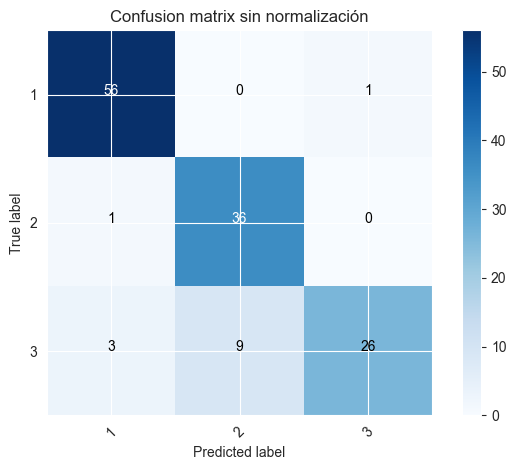

In [49]:
#Mostrar grafico de Matrix de confusion
cnf_matrix = confusion_matrix(array_clase_real, predictions_lab_real, labels=clases)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clases,
                      title='Confusion matrix sin normalización')

In [50]:
#Verificar el % de aciertos
print(classification_report(array_clase_real, predictions_lab_real))

              precision    recall  f1-score   support

           1       0.93      0.98      0.96        57
           2       0.80      0.97      0.88        37
           3       0.96      0.68      0.80        38

    accuracy                           0.89       132
   macro avg       0.90      0.88      0.88       132
weighted avg       0.90      0.89      0.89       132



In [51]:
#Cargar Dataset Preprocesado
df_pred = pd.read_csv('../data/processed/ANN/recomendaciones.csv')
df_pred.head()

,YEAR,MONTH,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion
0,1981,JAN,2.64,23.90,14.19,88.79,3.81,fertilizacion
1,1982,JAN,3.30,24.54,14.02,89.43,3.18,fertilizacion
2,1983,JAN,1.38,26.13,15.75,88.61,6.46,poda_preventiva
3,1984,JAN,0.69,23.68,13.14,87.41,8.35,riego
4,1985,JAN,1.94,23.45,14.37,86.96,8.05,riego


In [52]:
#Eliminar columnas y scalar con resultados anteriores
X_pred = df_pred.drop(['Recomendacion','YEAR','MONTH'], axis=1).values
X_pred

array([[ 2.64, 23.9 , 14.19, 88.79,  3.81],
       [ 3.3 , 24.54, 14.02, 89.43,  3.18],
       [ 1.38, 26.13, 15.75, 88.61,  6.46],
       ...,
       [ 3.39, 24.12, 15.47, 90.88,  7.8 ],
       [ 4.84, 25.7 , 16.68, 91.62,  6.58],
       [ 7.89, 24.69, 16.22, 93.15,  6.14]])

In [53]:
X_pred= scaler.fit_transform(X_pred)
#Realizamos predicción
resultado = np.argmax(model.predict(X_pred), axis=-1) + 1


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [54]:
resultado

array([1, 1, 2, 2, 2, 1, 2, 1, 3, 1, 1, 3, 3, 3, 3, 2, 1, 3, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2,
       1, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 1, 1,
       1, 3, 2, 1, 1, 2, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3,
       2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 1, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2,
       1, 2, 1, 2, 2, 3, 3, 2, 3, 3, 1, 3, 1, 3, 1, 1, 2, 3, 2, 1, 3, 1,
       1, 1, 3, 1, 2, 2, 1, 3, 1, 3, 1, 3, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1,
       2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2,

In [55]:
#Unimos en un dataframe los datos a predecir con su predicción
df_pred['PREDICCIÓN']=pd.DataFrame(resultado)
df_pred

,YEAR,MONTH,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion,PREDICCIÓN
0,1981,JAN,2.64,23.90,14.19,88.79,3.81,fertilizacion,1
1,1982,JAN,3.30,24.54,14.02,89.43,3.18,fertilizacion,1
2,1983,JAN,1.38,26.13,15.75,88.61,6.46,poda_preventiva,2
3,1984,JAN,0.69,23.68,13.14,87.41,8.35,riego,2
4,1985,JAN,1.94,23.45,14.37,86.96,8.05,riego,2
...,...,...,...,...,...,...,...,...,...
523,2020,DEC,10.77,24.26,13.57,91.87,6.02,poda_preventiva,2
524,2021,DEC,4.18,24.62,16.47,91.61,3.57,fertilizacion,1
525,2022,DEC,3.39,24.12,15.47,90.88,7.80,poda_preventiva,2
526,2023,DEC,4.84,25.70,16.68,91.62,6.58,poda_preventiva,2


In [58]:
import joblib
#Guardar el modelo
from tensorflow.keras.models import load_model
model.save('modelo_pred_cultivopapa.keras')
joblib.dump(scaler, '../models/scaler_ANN.pkl')

['../models/scaler_ANN.pkl']